In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import CatalogPrior
from smc.images import ImageAttributes

import torch
# torch.cuda.is_available()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

import matplotlib.pyplot as plt

In [2]:
num_images = 1
img_dim = 64 # Needs to be square for now
img_width = img_dim
img_height = img_dim
max_objects = 80
psf_stdev = 1
background_intensity = 19200

prior = CatalogPrior(max_objects = max_objects,
                     img_height = img_height,
                     img_width = img_width,
                     min_flux = background_intensity/3.)

image_attributes = ImageAttributes(img_height = img_height,
                                   img_width = img_width,
                                   max_objects = max_objects,
                                   psf_stdev = psf_stdev,
                                   background_intensity = background_intensity)

true_counts, true_fluxes, true_locs, true_total_intensities, images = image_attributes.generate(prior, num_images)

image 1 
count
 21 
total flux
 1482254.0 
loc
 [[58.169315  24.415436 ]
 [53.506084  57.178886 ]
 [ 7.4576902 28.47268  ]
 [63.533222  42.73473  ]
 [49.548004  36.656296 ]
 [46.516174   8.05065  ]
 [44.513077   9.369562 ]
 [47.05102   33.04128  ]
 [ 5.882034  58.84071  ]
 [35.195312  46.708847 ]
 [37.479614  63.486687 ]
 [54.88421   58.82054  ]
 [39.706924  41.66295  ]
 [36.725582  12.392845 ]
 [17.853563   0.371173 ]
 [32.303562  18.352316 ]
 [21.751146  38.862778 ]
 [53.344788  35.68708  ]
 [ 2.669595  23.520792 ]
 [24.386684  44.49948  ]
 [26.595463  15.66958  ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [ 0.         0.       ]
 [

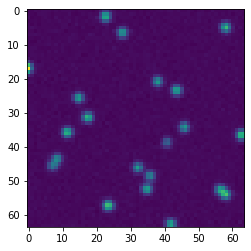

In [3]:
for i in range(num_images):
    print(f"image {i+1}",
          "\ncount\n", true_counts[i].round().item(),
          "\ntotal flux\n", true_fluxes[i].sum().item(),
          "\nloc\n", true_locs[i].cpu().numpy(), "\n\n")
    fig, img = plt.subplots(1,1)
    _ = img.imshow(images[i].cpu())

In [4]:
tile_side_length = 4
max_objects_smc = 2
pad = 2

prior = CatalogPrior(max_objects_smc,
                     img_width, img_height,
                     background_intensity/3.,
                     pad)

smc = SMCsampler(images[0], image_attributes, tile_side_length, prior,
                 num_blocks = max_objects_smc+1,
                 catalogs_per_block = 250, product_form_multiplier = 500,
                 max_smc_iters = 500)

print(f"True count: {true_counts[0]}")
print(f"True total flux: {true_fluxes[0].sum()}\n")

smc.run(print_progress = True)
smc.summarize()

True count: 21
True total flux: 1482254.0

Starting the tile samplers...
iteration 5, temperature = 0.00021598869352601469
iteration 10, temperature = 0.0007407646044157445
iteration 15, temperature = 0.0024116821587085724
iteration 20, temperature = 0.012808917090296745
iteration 25, temperature = 0.047725237905979156
iteration 30, temperature = 0.25591978430747986
iteration 35, temperature = 0.8606240153312683
iteration 40, temperature = 0.9956445097923279
iteration 45, temperature = 0.999863862991333
Done!

Combining the results...
Done!

Pruning detections...
Done!

summary
number of SMC iterations: 45
posterior mean count: 20.838031768798828
posterior mean total flux: 1455259.875
